In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorboardX

     |████████████████████████████████| 124 kB 5.2 MB/s 


In [ ]:
class Config:
    # dataset related
    exemplar_size = 127                    # exemplar size TEST
    instance_size = 255                    # instance size
    context_amount = 0.5                   # context amount
    scale_num = 3                          # the number of scale
    gpu_id = 0                             # gpu_id
    # training related
    train_per_epoch = 4880                 # num of samples per epoch
    val_per_epoch = 520                    
    frame_range = 100                      # frame range of choosing the instance
    train_batch_size = 8                   # training batch size
    valid_batch_size = 8                   # validation batch size
    train_num_workers = 8                  # number of workers of train dataloader
    valid_num_workers = 8                  # number of workers of validation dataloader
    lr = 1e-2                              # learning rate of SGD 0.01
    step_size = 25                         # step size of LR_Schedular
    gamma = 0.1                            # decay rate of LR_Schedular
    epoch = 30                             # total epoch
    seed = 1234                            # seed to sample training videos
    radius = 16                            # radius of positive label
    response_scale = 1e-3                  # normalize of response
    max_translate = 3                      # max translation of random shift
    momentum = 0.9                         # momentum of SGD
    weight_decay = 1e-4                    # weight decay of optimizator                      

    # tracking related
    train_response_sz = 17                 # train response size
    scale_step = 1.0375                    # scale step of instance image
    num_scale = 3                          # number of scales
    scale_lr = 0.59                        # scale learning rate
    response_up_stride = 16                # response upsample stride
    response_sz = 17                       # response size
    window_influence = 0.25                # window influence
    scale_penalty = 0.9745                 # scale penalty
    total_stride = 8                       # total stride of backbone
    gray_ratio = 0.25

config = Config()

In [ ]:
import cv2
import numpy as np
import glob
import os
from tqdm import tqdm
from concurrent import futures

datapath = '/content/drive/MyDrive/Colab Notebooks/validation'
outputpath = '/content/drive/MyDrive/Colab Notebooks/val_crop_'
num_processings = None
cfg = config
assert 1 == 2
def _init_video(video):

    frame_name_list = glob.glob(os.path.join(datapath, video)+'/**.jpg')
    frame_name_list.sort()

    try:
        gt_file = os.path.join(datapath, video, 'groundtruth.txt')
        try:
            gt = np.loadtxt(gt_file, dtype=float, delimiter=',')
        except:
            gt = np.loadtxt(gt_file, dtype=float)
    except:
        gt_file = os.path.join(datapath, video, 'groundtruth_rect.txt')
        try:
            gt = np.loadtxt(gt_file, dtype=float, delimiter=',')
        except:
            gt = np.loadtxt(gt_file, dtype=float)

    n_frames = len(frame_name_list)
    assert n_frames == len(gt), 'Number of frames and number of GT lines should be equal.'
    return gt, frame_name_list, n_frames

def get_center(x):
    return (x - 1.) / 2.

def xyxy2cxcywh(bbox):
    return get_center(bbox[0]+bbox[2]), get_center(bbox[1]+bbox[3]), (bbox[2]-bbox[0]), (bbox[3]-bbox[1])

def crop_and_pad(img, cx, cy, model_sz, original_sz, img_mean=None):
    xmin = cx - original_sz // 2
    xmax = cx + original_sz // 2
    ymin = cy - original_sz // 2
    ymax = cy + original_sz // 2
    im_h, im_w, _ = img.shape

    left = right = top = bottom = 0
    if xmin < 0:
        left = int(abs(xmin))
    if xmax > im_w:
        right = int(xmax - im_w)
    if ymin < 0:
        top = int(abs(ymin))
    if ymax > im_h:
        bottom = int(ymax - im_h)

    xmin = int(max(0, xmin))
    xmax = int(min(im_w, xmax))
    ymin = int(max(0, ymin))
    ymax = int(min(im_h, ymax))
    im_patch = img[ymin:ymax, xmin:xmax]
    if left != 0 or right !=0 or top!=0 or bottom!=0:
        if img_mean is None:
            img_mean = tuple(map(int, img.mean(axis=(0, 1))))
        im_patch = cv2.copyMakeBorder(im_patch, top, bottom, left, right,
                cv2.BORDER_CONSTANT, value=img_mean)
    if model_sz != original_sz:
        im_patch = cv2.resize(im_patch, (model_sz, model_sz))
    return im_patch

def get_instance_image(img, bbox, size_z, size_x, context_amount, img_mean=None):
    cx, cy, w, h = xyxy2cxcywh(bbox)
    wc_z = w + context_amount * (w+h)
    hc_z = h + context_amount * (w+h)
    s_z = np.sqrt(wc_z * hc_z)
    scale_z = size_z / s_z
    d_search = (size_x - size_z) / 2
    pad = d_search / scale_z
    s_x = s_z + 2 * pad
    scale_x = size_x / s_x
    instance_img = crop_and_pad(img, cx, cy, size_x, s_x, img_mean)
    return instance_img, scale_x, s_x

def crop_video(video):

    gt, frame_name_list, n_frames = _init_video(video)
    savepath = os.path.join(outputpath, video)
    if not os.path.exists(savepath):
        os.mkdir(savepath)
    for i in range(n_frames):
        img = cv2.imread(frame_name_list[i])
        img_mean = tuple(map(int, img.mean(axis=(0, 1))))
        bbox = gt[i]
        bbox = [int(bbox[0]), int(bbox[1]), int(bbox[0]+bbox[2]), int(bbox[1]+bbox[3])]
        instance_img, _, _ = get_instance_image(img, bbox,
                                                cfg.exemplar_size, cfg.instance_size, cfg.context_amount,
                                                img_mean)
        cv2.imwrite(savepath+"/{:0>8d}.x.jpg".format(i+1), instance_img)

if __name__ == '__main__':
    videos = os.listdir(datapath)
    videos.sort()
    for video in videos:
        crop_video(video)

In [ ]:
import torch
from torch import nn

class ChannelAttention(nn.Module):
    def __init__(self, input_channel: int, total_stride: int):
        super(ChannelAttention, self).__init__()

        self.mlp = nn.Sequential(
            nn.Conv2d(input_channel, input_channel // total_stride, 1, padding=0, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(input_channel // total_stride, input_channel, 1, padding=0, bias=False)
        )

        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        feat_avg = self.mlp(self.avg_pool(x))
        feat_max = self.mlp(self.max_pool(x))

        return self.sigmoid(feat_avg + feat_max)

class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()

        self.conv_layer = nn.Conv2d(2, 1, 7, padding=3, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        max_feature = torch.max(x, dim=1, keepdim=True)[0]
        avg_feature = torch.mean(x, dim=1, keepdim=True)

        feature_map = torch.cat((feat_avg, feat_max), dim=1)

        return self.sigmoid(self.conv_layer(feature_map))

In [ ]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F


class SiamFCNet(nn.Module):
    def __init__(self, training=True):
        super(SiamFCNet,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,96,11,2),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3,2),
            # nn.Dropout(p=0.02)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96,256,5,1, groups=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),
            # nn.Dropout(p=0.03)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            # nn.Dropout(p=0.05)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 192, 3, 1, groups=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.3)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(192,256,3,1, groups=2)
            # nn.Dropout(p=0.20)
        )
        # self.ca_mod1 = CBAM(96, config.total_stride)
        # self.ca_mod2 = CBAM(256, config.total_stride)
        # self.ca_mod3 = CBAM(384, config.total_stride)
        # self.ca_mod4 = CBAM(192, config.total_stride)
        # self.ca_mod5 = CBAM(256, config.total_stride)

        self.ca_mod1 = ChannelAttention(96, config.total_stride)
        self.sa_mod1 = SpatialAttention()
        self.ca_mod2 = ChannelAttention(256, config.total_stride)
        self.sa_mod2 = SpatialAttention()
        self.ca_mod3 = ChannelAttention(384, config.total_stride)
        self.sa_mod3 = SpatialAttention()
        self.ca_mod4 = ChannelAttention(192, config.total_stride)
        self.sa_mod4 = SpatialAttention()
        self.ca_mod5 = ChannelAttention(256, config.total_stride)
        self.sa_mod5 = SpatialAttention()

        # self.sa = SpatialAttention()


        self.relu = nn.ReLU(inplace=True)
        self.bais = nn.Parameter(torch.zeros(1))
        self.exemplar = None
        self.training = training

        if self.training:
            #generate label
            gt, weight = self.create_label((config.response_sz, config.response_sz))
            # Get labels and convert it to GPU
            with torch.cuda.device(0):
                self.train_gt = torch.from_numpy(gt).cuda()
                self.train_weight = torch.from_numpy(weight).cuda()
                self.valid_gt = torch.from_numpy(gt).cuda()
                self.valid_weight = torch.from_numpy(weight).cuda()
            
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    # def attention_module(self, feature_map):
    #     feature_out = self.ca(feature_map) * feature_map
    #     feature_out = self.sa(feature_out) * feature_out
    #     return self.relu(feature_out + feature_map)

    def forward(self, z, x):

        if z is not None and x is not None:
            feature_z = self.conv1(z)
            feature_z_ca = self.ca_mod1(feature_z) * feature_z
            # feature_z_ca = self.sa_mod1(feature_z_ca) * feature_z_ca
            feature_z = self.relu(feature_z + feature_z_ca)

            feature_z = self.conv2(feature_z)
            # feature_z_ca = self.ca_mod2(feature_z) * feature_z
            # feature_z_ca = self.sa_mod2(feature_z_ca) * feature_z_ca
            # feature_z = self.relu(feature_z + feature_z_ca)

            feature_z = self.conv3(feature_z)
            feature_z_ca = self.ca_mod3(feature_z) * feature_z
            # feature_z_ca = self.sa_mod3(feature_z_ca) * feature_z_ca
            feature_z = self.relu(feature_z + feature_z_ca)

            feature_z = self.conv4(feature_z)
            feature_z_ca = self.ca_mod4(feature_z) * feature_z
            # feature_z_ca = self.sa_mod4(feature_z_ca) * feature_z_ca
            feature_z = self.relu(feature_z + feature_z_ca)

            feature_z = self.conv5(feature_z)
            # feature_z_ca = self.ca_mod5(feature_z) * feature_z
            # feature_z_ca = self.sa_mod5(feature_z_ca) * feature_z_ca
            # feature_z = self.relu(feature_z + feature_z_ca) # shape = ([8, 256, 6, 6])

            feature_x = self.conv1(x)
            feature_x_ca = self.ca_mod1(feature_x) * feature_x
            # feature_x_ca = self.sa_mod1(feature_x_ca) * feature_x_ca
            feature_x = self.relu(feature_x + feature_x_ca)

            feature_x = self.conv2(feature_x)
            # feature_x_ca = self.ca_mod2(feature_x) * feature_x
            # feature_x_ca = self.sa_mod2(feature_x_ca) * feature_x_ca
            # feature_x = self.relu(feature_x + feature_x_ca)

            feature_x = self.conv3(feature_x)
            feature_x_ca = self.ca_mod3(feature_x) * feature_x
            # feature_x_ca = self.sa_mod3(feature_x_ca) * feature_x_ca
            feature_x = self.relu(feature_x + feature_x_ca)

            feature_x = self.conv4(feature_x)
            feature_x_ca = self.ca_mod4(feature_x) * feature_x
            # feature_x_ca = self.sa_mod4(feature_x_ca) * feature_x_ca
            feature_x = self.relu(feature_x + feature_x_ca)

            feature_x = self.conv5(feature_x)
            # feature_x_ca = self.ca_mod5(feature_x) * feature_x
            # feature_x_ca = self.sa_mod5(feature_x_ca) * feature_x_ca
            # feature_x = self.relu(feature_x + feature_x_ca) # shape = ([8, 256, 22, 22])

            N = feature_x.shape[0] # N = 8
            # reshape tensor by view [1, 2048, 22, 22]
            feature_x = feature_x.view(1, -1, feature_x.shape[2], feature_x.shape[3])
            score = F.conv2d(feature_x, feature_z, groups=N)*config.response_scale + self.bais
            score = score.view(N,-1,score.shape[2],score.shape[3]) # score shape ([8, 1, 17, 17])
            return score
        elif z is None and x is not None:
            feature_x = self.conv1(x)
            # feature_x_ca = self.ca_mod1(feature_x) * feature_x
            # feature_x = self.relu(feature_x + feature_x_ca)

            feature_x = self.conv2(feature_x)

            feature_x = self.conv3(feature_x)
            # feature_x_ca = self.ca_mod3(feature_x) * feature_x
            # feature_x = self.relu(feature_x + feature_x_ca)

            feature_x = self.conv4(feature_x)
            # feature_x_ca = self.ca_mod4(feature_x) * feature_x
            # feature_x = self.relu(feature_x + feature_x_ca)

            feature_x = self.conv5(feature_x) # shape = ([3, 256, 22, 22])
            
            N = feature_x.shape[0] #N = 3
            # reshape tensor by view [1, 768, 22, 22]
            feature_x = feature_x.view(1, -1, feature_x.shape[2], feature_x.shape[3])
            score = F.conv2d(feature_x, self.exemplar, groups=N) * config.response_scale + self.bais
            score = score.view(N, -1, score.shape[2], score.shape[3]) # score shape ([3, 1, 17, 17])
            return score
        else:
            self.exemplar = self.conv1(z)
            # exemplar_ca = self.ca_mod1(self.exemplar) * self.exemplar
            # self.exemplar = self.relu(self.exemplar + exemplar_ca)

            self.exemplar = self.conv2(self.exemplar)

            self.exemplar = self.conv3(self.exemplar)
            # exemplar_ca = self.ca_mod3(self.exemplar) * self.exemplar
            # self.exemplar = self.relu(self.exemplar + exemplar_ca)

            self.exemplar = self.conv4(self.exemplar)
            # exemplar_ca = self.ca_mod4(self.exemplar) * self.exemplar
            # self.exemplar = self.relu(self.exemplar + exemplar_ca)

            self.exemplar = self.conv5(self.exemplar)
            self.exemplar = torch.cat([self.exemplar for _ in range(3)], dim=0)



    def loss(self, pred):
        cost_function = nn.BCEWithLogitsLoss(weight=self.train_weight, reduction='sum')
        loss = cost_function(pred, self.train_gt) #/config.train_batch_size
        return loss
        
    def weighted_loss(self, pred):
        if self.training:
            return F.binary_cross_entropy_with_logits(pred, self.train_gt,
                    self.train_weight, reduction='sum') / config.train_batch_size # normalize the batch_size
        else:
            return F.binary_cross_entropy_with_logits(pred, self.valid_gt,
                    self.valid_weight, reduction='sum') / config.train_batch_size # normalize the batch_size
                    
    def create_label(self, shape):
        h, w = shape # 17 x 17
        # Values are generated within the half-open interval [start, stop) 
        y = np.arange(h, dtype=np.float32) - (h - 1) / 2.
        x = np.arange(w, dtype=np.float32) - (w - 1) / 2.
        y, x = np.meshgrid(y, x)
        dist = np.sqrt(x ** 2 + y ** 2)
        label = np.zeros((h, w)) 
        label[dist <= config.radius / config.total_stride] = 1

        #increase the dimension
        label = label[np.newaxis, :, :]

        #create same shape array with weights
        weights = np.ones_like(label)
        weights[label == 1] = 0.5 / np.sum(label == 1)
        weights[label == 0] = 0.5 / np.sum(label == 0)
        label = np.repeat(label, config.train_batch_size, axis=0)[:, np.newaxis, :, :]
        return label.astype(np.float32), weights.astype(np.float32)

In [ ]:
import torch
import cv2
import os
import numpy as np
from torch.utils.data.dataset import Dataset
np.random.seed(2)

class Dataset_GOT(Dataset):
    def __init__(self, data_dir, z_transforms, x_transforms, training=True):
        self.data_dir = data_dir
        self.videos = os.listdir(data_dir)
        self.z_transforms = z_transforms
        self.x_transforms = x_transforms
        if training:
            self.num = config.train_per_epoch
        else:
            self.num = config.val_per_epoch


    def __getitem__(self, index):
        index = index % len(self.videos)
        video = self.videos[index]
        video_path = os.path.join(self.data_dir, video)
        n_frames = len(os.listdir(video_path))
        z_id = np.random.choice(n_frames)
        z_path = os.path.join(video_path, "{:0>8d}.x.jpg".format(z_id+1))
        z = cv2.imread(z_path, cv2.IMREAD_COLOR)
        z = cv2.cvtColor(z, cv2.COLOR_BGR2RGB)
        low_limit = max(0, z_id - config.frame_range)
        up_limit = min(n_frames, z_id + config.frame_range)
        x_id = np.random.choice(range(low_limit,up_limit))
        x_path = os.path.join(video_path, "{:0>8d}.x.jpg".format(x_id+1))
        x = cv2.imread(x_path, cv2.IMREAD_COLOR)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        if np.random.rand(1) < config.gray_ratio: # data augmentation for gray image to color image
            z = cv2.cvtColor(z, cv2.COLOR_RGB2GRAY)
            z = cv2.cvtColor(z, cv2.COLOR_GRAY2RGB)
            x = cv2.cvtColor(x, cv2.COLOR_RGB2GRAY)
            x = cv2.cvtColor(x, cv2.COLOR_GRAY2RGB)
        z = self.z_transforms(z)
        x = self.x_transforms(x)
        return z, x

    def __len__(self):
        return self.num

In [ ]:
# import torch
# import numpy as np
# import cv2

class CenterCrop(object):
    def __init__(self, size):
        self.size = size

    def __call__(self, sample):
        shape = sample.shape[:2]
        cy, cx = (shape[0]-1) // 2, (shape[1]-1) // 2
        ymin, xmin = cy - self.size[0]//2, cx - self.size[1] // 2
        ymax, xmax = cy + self.size[0]//2 + self.size[0] % 2,\
                     cx + self.size[1]//2 + self.size[1] % 2
        left = right = top = bottom = 0
        im_h, im_w = shape
        if xmin < 0:
            left = int(abs(xmin))
        if xmax > im_w:
            right = int(xmax - im_w)
        if ymin < 0:
            top = int(abs(ymin))
        if ymax > im_h:
            bottom = int(ymax - im_h)

        xmin = int(max(0, xmin))
        xmax = int(min(im_w, xmax))
        ymin = int(max(0, ymin))
        ymax = int(min(im_h, ymax))
        im_patch = sample[ymin:ymax, xmin:xmax]
        if left != 0 or right !=0 or top!=0 or bottom!=0:
            im_patch = cv2.copyMakeBorder(im_patch, top, bottom, left, right,
                    cv2.BORDER_CONSTANT, value=0)
        return im_patch

class RandomCrop(object):
    def __init__(self, size, max_translate):
        self.size = size
        self.max_translate = max_translate

    def __call__(self, sample):
        shape = sample.shape[:2]
        cy_o = (shape[0] - 1) // 2
        cx_o = (shape[1] - 1) // 2
        cy = np.random.randint(cy_o - self.max_translate, 
                               cy_o + self.max_translate+1)
        cx = np.random.randint(cx_o - self.max_translate,
                               cx_o + self.max_translate+1)
        assert abs(cy-cy_o) <= self.max_translate and \
                abs(cx-cx_o) <= self.max_translate
        ymin = cy - self.size[0] // 2
        xmin = cx - self.size[1] // 2
        ymax = cy + self.size[0] // 2 + self.size[0] % 2
        xmax = cx + self.size[1] // 2 + self.size[1] % 2
        left = right = top = bottom = 0
        im_h, im_w = shape
        if xmin < 0:
            left = int(abs(xmin))
        if xmax > im_w:
            right = int(xmax - im_w)
        if ymin < 0:
            top = int(abs(ymin))
        if ymax > im_h:
            bottom = int(ymax - im_h)

        xmin = int(max(0, xmin))
        xmax = int(min(im_w, xmax))
        ymin = int(max(0, ymin))
        ymax = int(min(im_h, ymax))
        im_patch = sample[ymin:ymax, xmin:xmax]
        if left != 0 or right !=0 or top!=0 or bottom!=0:
            im_patch = cv2.copyMakeBorder(im_patch, top, bottom, left, right,
                    cv2.BORDER_CONSTANT, value=0)
        return im_patch

class RandomStretch(object):
    def __init__(self, max_stretch=0.05):
        self.max_stretch = max_stretch

    def __call__(self, sample):
        scale_h = 1.0 + np.random.uniform(-self.max_stretch, self.max_stretch)
        scale_w = 1.0 + np.random.uniform(-self.max_stretch, self.max_stretch)
        h, w = sample.shape[:2]
        shape = (int(h * scale_h), int(w * scale_w))
        return cv2.resize(sample, shape, cv2.INTER_LINEAR)

class ToTensor(object):
    def __call__(self, sample):
        sample = sample.transpose(2, 0, 1)
        return torch.from_numpy(sample.astype(np.float32))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 65/65 [00:06<00:00, 10.21it/s]


EPOCH 0 valid_loss: 0.3154, train_loss: 0.3479, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00, 10.24it/s]


EPOCH 1 valid_loss: 0.2898, train_loss: 0.2317, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00,  9.93it/s]


EPOCH 2 valid_loss: 0.2843, train_loss: 0.1951, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00, 10.20it/s]


EPOCH 3 valid_loss: 0.3173, train_loss: 0.1741, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00,  9.93it/s]


EPOCH 4 valid_loss: 0.3075, train_loss: 0.1574, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00, 10.24it/s]


EPOCH 5 valid_loss: 0.3122, train_loss: 0.1495, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00, 10.12it/s]


EPOCH 6 valid_loss: 0.3248, train_loss: 0.1379, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00, 10.30it/s]


EPOCH 7 valid_loss: 0.3223, train_loss: 0.1315, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00,  9.85it/s]


EPOCH 8 valid_loss: 0.2973, train_loss: 0.1248, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00, 10.10it/s]


EPOCH 9 valid_loss: 0.3688, train_loss: 0.1216, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00, 10.11it/s]


EPOCH 10 valid_loss: 0.3179, train_loss: 0.1144, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00,  9.93it/s]


EPOCH 11 valid_loss: 0.4056, train_loss: 0.1138, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00,  9.98it/s]


EPOCH 12 valid_loss: 0.2819, train_loss: 0.1097, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00, 10.18it/s]


EPOCH 13 valid_loss: 0.3575, train_loss: 0.1039, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00, 10.31it/s]


EPOCH 14 valid_loss: 0.4588, train_loss: 0.1034, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00, 10.34it/s]


EPOCH 15 valid_loss: 0.2722, train_loss: 0.1008, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00, 10.06it/s]


EPOCH 16 valid_loss: 0.3067, train_loss: 0.0966, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00, 10.03it/s]


EPOCH 17 valid_loss: 0.2946, train_loss: 0.0940, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00,  9.91it/s]


EPOCH 18 valid_loss: 0.3843, train_loss: 0.0955, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00, 10.42it/s]


EPOCH 19 valid_loss: 0.3065, train_loss: 0.0942, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00, 10.05it/s]


EPOCH 20 valid_loss: 0.3065, train_loss: 0.0911, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00, 10.15it/s]


EPOCH 21 valid_loss: 0.3024, train_loss: 0.0865, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00, 10.41it/s]


EPOCH 22 valid_loss: 0.3220, train_loss: 0.0856, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00, 10.36it/s]


EPOCH 23 valid_loss: 0.2904, train_loss: 0.0860, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00, 10.30it/s]


EPOCH 24 valid_loss: 0.3115, train_loss: 0.0855, learning_rate: 0.0100


100%|██████████| 65/65 [00:06<00:00, 10.32it/s]


EPOCH 25 valid_loss: 0.2811, train_loss: 0.0757, learning_rate: 0.0010


100%|██████████| 65/65 [00:06<00:00, 10.30it/s]


EPOCH 26 valid_loss: 0.2662, train_loss: 0.0721, learning_rate: 0.0010


100%|██████████| 65/65 [00:06<00:00, 10.13it/s]


EPOCH 27 valid_loss: 0.2888, train_loss: 0.0707, learning_rate: 0.0010


100%|██████████| 65/65 [00:06<00:00, 10.20it/s]


EPOCH 28 valid_loss: 0.2825, train_loss: 0.0698, learning_rate: 0.0010


100%|██████████| 65/65 [00:06<00:00, 10.20it/s]


EPOCH 29 valid_loss: 0.3032, train_loss: 0.0695, learning_rate: 0.0010




total_train_loss [0.34789103, 0.23174313, 0.19510631, 0.17406827, 0.15736702, 0.14949118, 0.13787931, 0.13151978, 0.12476426, 0.121572785, 0.11435379, 0.11384258, 0.10967743, 0.10394391, 0.103399664, 0.100762844, 0.09658687, 0.09396016, 0.09545533, 0.094175845, 0.09110993, 0.08647476, 0.08556662, 0.08596877, 0.08549381, 0.07567437, 0.07212202, 0.07071772, 0.069846354, 0.0694942]
total_val_loss [0.31541908, 0.28976026, 0.28434727, 0.317297, 0.30752215, 0.31224054, 0.32481217, 0.32228473, 0.2973034, 0.3687703, 0.31790432, 0.40560472, 0.2818659, 0.35750666, 0.4588119, 0.2722092, 0.30671728, 0.29464102, 0.3843274, 0.30651546, 0.30648914, 0.30235913, 0.32199302, 0.29039267, 0.31145346, 0.28107348, 0.26619515, 0.28875953, 0.282545, 0.3031915]


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


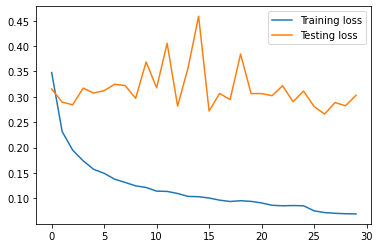

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import numpy as np
import os
import cv2
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from glob import glob
from tqdm import tqdm
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
import sys

torch.manual_seed(1234)

train_data_dir = '/content/drive/MyDrive/Colab Notebooks/train_crop'
val_data_dir = '/content/drive/MyDrive/Colab Notebooks/val_crop'

def main():


    train_z_transforms = transforms.Compose([
        RandomStretch(),
        CenterCrop((config.exemplar_size, config.exemplar_size)),
        ToTensor()
    ])
    train_x_transforms = transforms.Compose([
        RandomStretch(),
        RandomCrop((config.instance_size, config.instance_size),
                   config.max_translate),
        ToTensor()
    ])
    val_z_transforms = transforms.Compose([
        CenterCrop((config.exemplar_size, config.exemplar_size)),
        ToTensor()
    ])
    val_x_transforms = transforms.Compose([
        ToTensor()
    ])

    # create training dataset & validation dataset
    train_dataset = Dataset_GOT(train_data_dir, train_z_transforms, train_x_transforms)
    valid_dataset = Dataset_GOT(val_data_dir, val_z_transforms, val_x_transforms, training=False)

    trainloader = DataLoader(train_dataset, batch_size=config.train_batch_size,
                             shuffle=True, pin_memory=True, num_workers=config.train_num_workers, drop_last=True)
    validloader = DataLoader(valid_dataset, batch_size=config.valid_batch_size,
                             shuffle=False, pin_memory=True, num_workers=config.valid_num_workers, drop_last=True)

    # training-start
    with torch.cuda.device(0):
        total_train_loss = []
        total_val_loss = []
        model = SiamFCNet()
        model.init_weights()
        model = model.cuda()
        optimizer = torch.optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay)
        schdeuler = StepLR(optimizer, step_size=config.step_size,
                           gamma=config.gamma)

        for epoch in range(config.epoch):
            train_loss = []
            model.train()
            for i, data in enumerate(tqdm(trainloader)):
                z, x = data
                z, x = Variable(z.cuda()), Variable(x.cuda())
                optimizer.zero_grad()
                outputs = model(z, x)
                loss = model.weighted_loss(outputs)
                loss.backward()
                optimizer.step()
                step = epoch * len(trainloader) + i
                train_loss.append(loss.data.cpu().numpy())
            train_loss = np.mean(train_loss)
            total_train_loss.append(train_loss)
            valid_loss = []
            model.eval()
            for i, data in enumerate(tqdm(validloader)):
                z, x = data
                z, x = Variable(z.cuda()), Variable(x.cuda())
                outputs = model(z, x)
                loss = model.weighted_loss(outputs)
                valid_loss.append(loss.data.cpu().numpy())
            valid_loss = np.mean(valid_loss)
            total_val_loss.append(valid_loss)
            print("EPOCH %d valid_loss: %.4f, train_loss: %.4f, learning_rate: %.4f" %
                  (epoch, valid_loss, train_loss, optimizer.param_groups[0]["lr"]))
            torch.save(model.cpu().state_dict(),
                       "/content/drive/MyDrive/Colab Notebooks/model_new3/siamfc_{}.pth".format(epoch + 1))
            model.cuda()
            schdeuler.step()

        plt.plot(total_train_loss, label = "Training loss")
        plt.plot(total_val_loss, label = "Testing loss")
        plt.legend()
        print('')
        print('')
        print('')
        print('')
        print('total_train_loss', total_train_loss)
        print('total_val_loss', total_val_loss)

if __name__ == '__main__':
    sys.exit(main())

In [ ]:
import numpy as np

def region_to_bbox(region, center=True):

    n = len(region)
    assert n==4 or n==8, ('GT region format is invalid, should have 4 or 8 entries.')

    if n==4:
        return _rect(region, center)
    else:
        return _poly(region, center)

# we assume the grountruth bounding boxes are saved with 0-indexing
def _rect(region, center):
    
    if center:
        x = region[0]
        y = region[1]
        w = region[2]
        h = region[3]
        cx = x+w/2
        cy = y+h/2
        return cx, cy, w, h
    else:
        #region[0] -= 1
        #region[1] -= 1
        return region


def _poly(region, center):
    cx = np.mean(region[::2])
    cy = np.mean(region[1::2])
    x1 = np.min(region[::2])
    x2 = np.max(region[::2])
    y1 = np.min(region[1::2])
    y2 = np.max(region[1::2])
    A1 = np.linalg.norm(region[0:2] - region[2:4]) * np.linalg.norm(region[2:4] - region[4:6])
    A2 = (x2 - x1) * (y2 - y1)
    s = np.sqrt(A1/A2)
    w = s * (x2 - x1) + 1
    h = s * (y2 - y1) + 1

    if center:
        return cx, cy, w, h
    else:
        return cx-w/2, cy-h/2, w, h

In [ ]:
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import time
import warnings
import torchvision.transforms as transforms

from torch.autograd import Variable

torch.set_num_threads(1) # otherwise pytorch will take all cpus

class SiamFCTracker:
    def __init__(self, model_path, gpu_id):
        self.gpu_id = gpu_id
        with torch.cuda.device(gpu_id):
            self.model = SiamFCNet(training=False)
            self.model.load_state_dict(torch.load(model_path))
            self.model = self.model.cuda()
            self.model.eval() 
        self.transforms = transforms.Compose([
            ToTensor()
        ])

    def _cosine_window(self, size):
        """
            focuses on the central region of target and weakens the background information near the bounding box edge
        """
        cos_window = np.hanning(int(size[0]))[:, np.newaxis].dot(np.hanning(int(size[1]))[np.newaxis, :])
        cos_window = cos_window.astype(np.float32)
        cos_window /= np.sum(cos_window)
        return cos_window

    def init(self, frame, bbox):
        # bbox: [x, y, width, height]
        self.bbox = (bbox[0]-1, bbox[1]-1, bbox[0]-1+bbox[2], bbox[1]-1+bbox[3]) # zero based
        self.pos = np.array([bbox[0]-1+(bbox[2]-1)/2, bbox[1]-1+(bbox[3]-1)/2])  # center x, center y, zero based
        self.target_sz = np.array([bbox[2], bbox[3]])                            # width, height
        # get exemplar img
        self.img_mean = tuple(map(int, frame.mean(axis=(0, 1)))) # Calculate mean color
        exemplar_img, scale_z, s_z = get_exemplar_image(frame, self.bbox,
                config.exemplar_size, config.context_amount, self.img_mean)

        # get exemplar feature
        exemplar_img = self.transforms(exemplar_img)[None,:,:,:] #(127, 127, 3) to (3, 127, 127)

        with torch.cuda.device(self.gpu_id):
            exemplar_img_var = Variable(exemplar_img.cuda())
            self.model(exemplar_img_var, None)

        self.penalty = np.ones((config.num_scale)) * config.scale_penalty
        self.penalty[config.num_scale//2] = 1 #[0.9745 1.     0.9745]

        # create cosine window
        """upsampling score map for more accurate localization
           from window & interpolation, can reduce the effect due to spectral leakage in sampling process
        """
        self.interp_response_sz = config.response_up_stride * config.response_sz #bicubic interpolation, from 17 × 17 to 272 × 272 - accurate localization
        self.cosine_window = self._cosine_window((self.interp_response_sz, self.interp_response_sz))

        # create scalse
        """ handle scale variations, we also search for the object over three scales. [-1, 0, 1] """
        self.scales = config.scale_step ** np.arange(np.ceil(config.num_scale/2)-config.num_scale,
                np.floor(config.num_scale/2)+1)

        # create s_x
        self.s_x = s_z + (config.instance_size-config.exemplar_size) / scale_z

        # arbitrary scale saturation
        self.min_s_x = 0.2 * self.s_x 
        self.max_s_x = 5 * self.s_x

    def update(self, frame):
        # make three scales
        size_x_scales = self.s_x * self.scales
        # make three different scaled image. shape (255, 255, 3) 
        pyramid = get_scaled_instance_image(frame, self.pos, config.instance_size, size_x_scales, self.img_mean)
        instance_imgs = torch.cat([self.transforms(x)[None,:,:,:] for x in pyramid], dim=0)

        with torch.cuda.device(self.gpu_id):
            instance_imgs_var = Variable(instance_imgs.cuda())
            response_maps = self.model(None, instance_imgs_var)
            response_maps = response_maps.data.cpu().numpy().squeeze() # (3, 17, 17)
            #bicubic interpolation over square pixel neighborhoods
            response_maps_up = [cv2.resize(x, (self.interp_response_sz, self.interp_response_sz), cv2.INTER_CUBIC)
             for x in response_maps]
        # get max score
        max_score = np.array([x.max() for x in response_maps_up]) * self.penalty

        # penalty scale change
        scale_idx = max_score.argmax() #index which have max score
        response_map = response_maps_up[scale_idx]
        response_map -= response_map.min()
        response_map /= response_map.sum()
        response_map = (1 - config.window_influence) * response_map + \
                config.window_influence * self.cosine_window
        max_r, max_c = np.unravel_index(response_map.argmax(), response_map.shape)

        # displacement in interpolation response
        disp_response_interp = np.array([max_c, max_r]) - (self.interp_response_sz-1) / 2.
        # displacement in input
        disp_response_input = disp_response_interp * config.total_stride / config.response_up_stride
        # displacement in frame
        scale = self.scales[scale_idx]
        disp_response_frame = disp_response_input * (self.s_x * scale) / config.instance_size
        # position in frame coordinates
        self.pos += disp_response_frame
        # scale damping and saturation
        self.s_x *= ((1 - config.scale_lr) + config.scale_lr * scale)
        self.s_x = max(self.min_s_x, min(self.max_s_x, self.s_x))
        self.target_sz = ((1 - config.scale_lr) + config.scale_lr * scale) * self.target_sz
        bbox = (self.pos[0] - self.target_sz[0]/2 + 1, # xmin   convert to 1-based
                self.pos[1] - self.target_sz[1]/2 + 1, # ymin
                self.pos[0] + self.target_sz[0]/2 + 1, # xmax
                self.pos[1] + self.target_sz[1]/2 + 1) # ymax
        return bbox #1-based bounding box(xmin, ymin, xmax, ymax)

In [ ]:
import numpy as np
import cv2

def get_center(x):
    return (x - 1.) / 2.

def xyxy2cxcywh(bbox):
    return get_center(bbox[0]+bbox[2]), \
           get_center(bbox[1]+bbox[3]), \
           (bbox[2]-bbox[0]), \
           (bbox[3]-bbox[1])

def crop_and_pad(img, cx, cy, model_sz, original_sz, img_mean=None):
    xmin = cx - original_sz // 2
    xmax = cx + original_sz // 2
    ymin = cy - original_sz // 2
    ymax = cy + original_sz // 2
    im_h, im_w, _ = img.shape

    left = right = top = bottom = 0
    if xmin < 0:
        left = int(abs(xmin))
    if xmax > im_w:
        right = int(xmax - im_w)
    if ymin < 0:
        top = int(abs(ymin))
    if ymax > im_h:
        bottom = int(ymax - im_h)

    xmin = int(max(0, xmin))
    xmax = int(min(im_w, xmax))
    ymin = int(max(0, ymin))
    ymax = int(min(im_h, ymax))
    im_patch = img[ymin:ymax, xmin:xmax]
    if left != 0 or right !=0 or top!=0 or bottom!=0:
        if img_mean is None:
            img_mean = tuple(map(int, img.mean(axis=(0, 1))))
        im_patch = cv2.copyMakeBorder(im_patch, top, bottom, left, right,
                cv2.BORDER_CONSTANT, value=img_mean)
    if model_sz != original_sz:
        im_patch = cv2.resize(im_patch, (model_sz, model_sz))
    return im_patch

def get_exemplar_image(img, bbox, size_z, context_amount, img_mean=None):
    # xyxy to cxcywh convertion
    cx, cy, w, h = xyxy2cxcywh(bbox)
    # s(w + 2p) × s(h + 2p) = exemplar_size
    wc_z = w + context_amount * (w+h)
    hc_z = h + context_amount * (w+h)
    s_z = np.sqrt(wc_z * hc_z)
    scale_z = size_z / s_z
    exemplar_img = crop_and_pad(img, cx, cy, size_z, s_z, img_mean)
    return exemplar_img, scale_z, s_z

def get_scaled_instance_image(img, center, size_x, size_x_scales, img_mean=None):
    if img_mean is None:
        img_mean = tuple(map(int, img.mean(axis=(0, 1))))
    pyramid = [crop_and_pad(img, center[0], center[1], size_x, size_x_scale, img_mean)
            for size_x_scale in size_x_scales]
    return pyramid

In [ ]:
import cv2
import numpy as np
import time
from google.colab.patches import cv2_imshow
import glob
import os
import time


data_dir = '/content/drive/MyDrive/Colab Notebooks/test4'
model_dir = '/content/drive/MyDrive/Colab Notebooks/model_new3/siamfc_30.pth'
outputpath = '/content/drive/MyDrive/Colab Notebooks/video7'

def _init_video(datapath, video):

    frame_name_list = glob.glob(os.path.join(datapath, video)+'/**.jpg')
    frame_name_list.sort()

    try:
        gt_file = os.path.join(datapath, video, 'groundtruth.txt')
        try:
            gt = np.loadtxt(gt_file, dtype=float, delimiter=',')
        except:
            gt = np.loadtxt(gt_file, dtype=float)
    except:
        gt_file = os.path.join(datapath, video, 'groundtruth_rect.txt')
        try:
            gt = np.loadtxt(gt_file, dtype=float, delimiter=',')
        except:
            gt = np.loadtxt(gt_file, dtype=float)

    n_frames = len(frame_name_list)

    # count of frames eqal to length of ground truth
    # assert n_frames == len(gt)
    return gt, frame_name_list, n_frames


def run_SiamFC():


    videolist = os.listdir(data_dir)
    videolist.sort()
    video_count = len(videolist)
    precision_all = 0
    iou_all = 0
    fps_all = 0

    for video in videolist:
        gt, frame_name_list, n_frames = _init_video(data_dir, video)
        bboxs = np.zeros((n_frames, 4)) # create matrix to save all bbox values
        path_cor = [] # create matrix to save all path coordinates
        tracker = SiamFCTracker(model_dir, config.gpu_id)
        
        start = time.time()
        for i in range(n_frames):
            # Open CV use BGR color. Convert BGR to RGB
            frame = cv2.imread(frame_name_list[i], cv2.IMREAD_COLOR)
            frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
            if i==0:
                tracker.init(frame, gt)
                bbox = gt
                bbox = (bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3])
            else:
                bbox = tracker.update(frame)

            bboxs[i] = [bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]]
            path_cor.append([int((bbox[2] + bbox[0])/2), int(bbox[3]+ ((bbox[1]-bbox[3])/10))])

            pts = np.array(path_cor, np.int32)
            pts = pts.reshape((-1, 1, 2))
            cv2.polylines(frame, [pts], isClosed = False,color = (0,255,0),thickness = 3)

            # visualization
            cv2.rectangle(frame,(int(bbox[0]),int(bbox[1])),(int(bbox[2]),int(bbox[3])),(255,0,0),thickness=2)
            frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)
            # cv2_imshow(frame)
            savepath = os.path.join(outputpath, video)
            if not os.path.exists(savepath):
                os.mkdir(savepath)
            # path = savepath+str(i)+'new.jpg'
            cv2.imwrite(savepath+"/{:0>8d}.jpg".format(i+1), frame)

            end = time.time()
            fps = 1/ ((end-start)/n_frames)
        _, precision, _, iou = compile_results(gt, bboxs, 20)
        print("video " + ' -- ' + str(video) + "  Precision: " + str(precision) + "  IOU: " + str(iou) + "  FPS: " + str(fps))
        precision_all = precision_all + precision
        iou_all = iou_all + iou
        fps_all = fps_all + fps

    P = precision_all / video_count
    I = iou_all / video_count
    F = fps_all / video_count
    print("averge_Precision:" + str(P))
    print("averge_IOU:" + str(I))
    print("averge_FPS:" + str(F))
    # out.release()


def compile_results(gt, bboxes, dist_threshold):
    l = np.size(bboxes, 0)
    gt4 = np.zeros((l, 4))
    new_distances = np.zeros(l)
    new_ious = np.zeros(l)
    n_thresholds = 50
    precisions_ths = np.zeros(n_thresholds)

    for i in range(l):
        gt4[i, :] = region_to_bbox(gt, center=False)
        new_distances[i] = compute_distance(bboxes[i, :], gt4[i, :])
        new_ious[i] = compute_iou(bboxes[i, :], gt4[i, :])

    # what's the percentage of frame in which center displacement is inferior to given threshold? (OTB metric)
    precision = sum(new_distances < dist_threshold)/np.size(new_distances) * 100

    # find above result for many thresholds, then report the AUC
    thresholds = np.linspace(0, 25, n_thresholds+1)
    thresholds = thresholds[-n_thresholds:]
    # reverse it so that higher values of precision goes at the beginning
    thresholds = thresholds[::-1]
    for i in range(n_thresholds):
        precisions_ths[i] = sum(new_distances < thresholds[i])/np.size(new_distances)

    # integrate over the thresholds
    precision_auc = np.trapz(precisions_ths)

    # per frame averaged intersection over union (OTB metric)
    iou = np.mean(new_ious) * 100

    return l, precision, precision_auc, iou

def compute_iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

    if xA < xB and yA < yB:
        # compute the area of intersection rectangle
        interArea = (xB - xA) * (yB - yA)
        # compute the area of both the prediction and ground-truth
        # rectangles
        boxAArea = boxA[2] * boxA[3]
        boxBArea = boxB[2] * boxB[3]
        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the intersection area
        iou = interArea / float(boxAArea + boxBArea - interArea)
    else:
        iou = 0

    assert iou >= 0
    assert iou <= 1.01
    return iou

def compute_distance(boxA, boxB):
    a = np.array((boxA[0]+boxA[2]/2, boxA[1]+boxA[3]/2))
    b = np.array((boxB[0]+boxB[2]/2, boxB[1]+boxB[3]/2))
    dist = np.linalg.norm(a - b)

    assert dist >= 0
    assert dist != float('Inf')
    return dist



if __name__ == '__main__':
    run_SiamFC()

video  -- GOT-10k_Val_000039 (1)  Precision: 12.222222222222221  IOU: 23.415356571962384  FPS: 13.272626234373595
averge_Precision:12.222222222222221
averge_IOU:23.415356571962384
averge_FPS:13.272626234373595


In [ ]:
import cv2
import numpy as np
import time
from google.colab.patches import cv2_imshow
import glob
import os
import time


data_dir = '/content/drive/MyDrive/Colab Notebooks/video7/GOT-10k_Test_000121'

frame_name_list = glob.glob(os.path.join(data_dir)+'/**.jpg')
print(frame_name_list)

def write(frames, show=False):
        out = None

        try:
            for i in range(len(frames)):
                frame = cv2.imread(frames[i], cv2.IMREAD_COLOR)
                if show:
                    cv2.imshow('video', frame)

                if not out:
                    height, width, channels = frame.shape
                    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                    out = cv2.VideoWriter('/content/drive/MyDrive/Colab Notebooks/test4/example22.mp4', fourcc, 12, (width, height))

                out.write(frame)

        finally:
            out and out.release()
            cv2.destroyAllWindows() 

write(frame_name_list, show=False)

['/content/drive/MyDrive/Colab Notebooks/video7/GOT-10k_Test_000121/00000001.jpg', '/content/drive/MyDrive/Colab Notebooks/video7/GOT-10k_Test_000121/00000002.jpg', '/content/drive/MyDrive/Colab Notebooks/video7/GOT-10k_Test_000121/00000003.jpg', '/content/drive/MyDrive/Colab Notebooks/video7/GOT-10k_Test_000121/00000004.jpg', '/content/drive/MyDrive/Colab Notebooks/video7/GOT-10k_Test_000121/00000005.jpg', '/content/drive/MyDrive/Colab Notebooks/video7/GOT-10k_Test_000121/00000006.jpg', '/content/drive/MyDrive/Colab Notebooks/video7/GOT-10k_Test_000121/00000007.jpg', '/content/drive/MyDrive/Colab Notebooks/video7/GOT-10k_Test_000121/00000008.jpg', '/content/drive/MyDrive/Colab Notebooks/video7/GOT-10k_Test_000121/00000009.jpg', '/content/drive/MyDrive/Colab Notebooks/video7/GOT-10k_Test_000121/00000010.jpg', '/content/drive/MyDrive/Colab Notebooks/video7/GOT-10k_Test_000121/00000011.jpg', '/content/drive/MyDrive/Colab Notebooks/video7/GOT-10k_Test_000121/00000012.jpg', '/content/drive